In this example, we provide an analysis of a biochemical network. The discussed system describes the influence of the Raf Kinase Inhibitor Protein (RKIP). For more details please follow [Gilbert, David & Heiner, Monika. (2006). From Petri nets to differential equations - An integrative approach for biochemical network analysis. 181-200.](https://www.researchgate.net/publication/299157975_From_Petri_nets_to_differential_equations_-_An_integrative_approach_for_biochemical_network_analysis). In the article the influence of RKIP is investigated via numerical analysis of nonlinear ordinary differential equations. We will demonstrate how to build a Lie transform--based neural network that can be used as an accurate model of the system. So instead of using a numerical integration method one can build a neural network and utilize it for system simulation or identification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import sys
sys.path.insert(0,'..')

from core.Lie import LieLayer
from core.Lie_map_builder import LieMapBuilder

from sympy import Symbol

Using TensorFlow backend.


At the begining let's define a system of ordinary differential equations that describe or RKIP dynamics ([see article](https://www.researchgate.net/publication/299157975_From_Petri_nets_to_differential_equations_-_An_integrative_approach_for_biochemical_network_analysis)).

In [2]:
m1 = Symbol('m01');    m2 = Symbol('m02');    m3 = Symbol('m03');    m4 = Symbol('m04')
m5 = Symbol('m05');    m6 = Symbol('m06');    m7 = Symbol('m07');    m8 = Symbol('m08')
m9 = Symbol('m09');    m10 = Symbol('m10');   m11 = Symbol('m11')

k1 = 0.53;    k2 = 0.0072;    k3 = 0.625;    k4 = 0.00245
k5 = 0.0315;  k6 = 0.6;       k7 = 0.0075;   k8 = 0.071
k9 = 0.92;    k10 = 0.00122;  k11 = 0.87

r1 = k1*m1*m2;    r2 = k2*m3;    r3 = k3*m3*m9;    r4 = k4*m4
r5 = k5*m4;       r6 = k6*m5*m7; r7 = k7*m8;       r8 = k8*m8
r9 = k9*m6*m10;   r10 = k10*m11; r11 = k11*m11

right_hand_side = [
    r2+r5-r1,
    r2+r11-r1,
    r1+r4-r2-r3,
    r3-r4-r5,
    r5+r7-r6,
    r5+r10-r9,
    r7+r8-r6,
    r6-r7-r8,
    r4+r8-r3,
    r10+r11-r9,
    r9-r10-r11]

Next one can build a tensor Lie map for the given system

In [4]:
state = np.array([m1, m2, m3, m4, m5, m6, m7, m8, m9, m10, m11])
map_builder = LieMapBuilder(state, right_hand_side, order=3)
R = map_builder.getInitR()
# uncomment the line for map calculation
# R = map_builder.propogate(h=0.002, N=5) # the resulting map corresponds to dynamics in h*n sec
# with open('map.pkl', 'wb') as file:
#     pickle.dump(R, file)

with open('map.pkl', 'rb') as file:
    R = pickle.load(file)

[m01 m02 m03 m04 m05 m06 m07 m08 m09 m10 m11]
[-0.53*m01*m02 + 0.0072*m03 + 0.0315*m04, -0.53*m01*m02 + 0.0072*m03 + 0.87*m11, 0.53*m01*m02 - 0.625*m03*m09 - 0.0072*m03 + 0.00245*m04, 0.625*m03*m09 - 0.03395*m04, 0.0315*m04 - 0.6*m05*m07 + 0.0075*m08, 0.0315*m04 - 0.92*m06*m10 + 0.00122*m11, -0.6*m05*m07 + 0.0785*m08, 0.6*m05*m07 - 0.0785*m08, -0.625*m03*m09 + 0.00245*m04 + 0.071*m08, -0.92*m06*m10 + 0.87122*m11, 0.92*m06*m10 - 0.87122*m11]


and load the calculated matrices as the neural network weights:

In [5]:
W = map_builder.convert_weights_to_full_nn(R)
dim = len(state)

map = LieLayer(output_dim = dim, order = 2, input_shape = (dim,))
model = Sequential()
model.add(map)
map.set_weights(W)

Instructions for updating:
Colocations handled automatically by placer.


Now we have a polynomial neural network that accuratle descrybes biochemical RKIP dynamics. One can use this neural network either for simulation or for system identification. E.g. defined aboved equations or factors may vary in real systems, and can be identified throw neural network fitting on measured data. As an example, lets repeat a numerical experiment that presented in the [article](https://www.researchgate.net/publication/299157975_From_Petri_nets_to_differential_equations_-_An_integrative_approach_for_biochemical_network_analysis). Note that authors use numerical method for dynamics simulation, while we utilize prebuilt neural network.

start simulation
elapsed time: 4.27122092247 sec


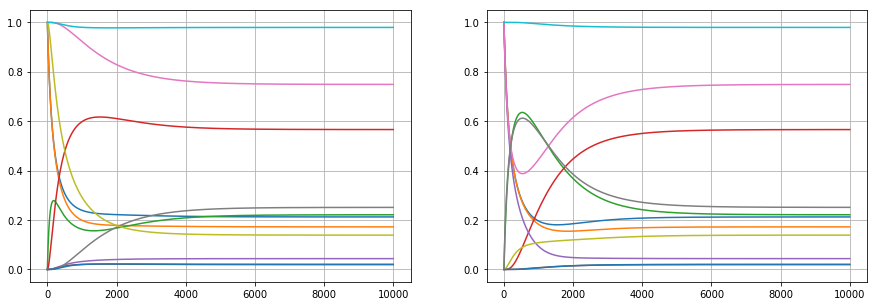

In [14]:
# initial states of species
X0 = np.array([[1,1,0,0,0,0,1,0,1,1,0],
               [1,1,0,0,1,0,1,0,0,1,0]],
               dtype=float).reshape((-1, 11))

X = []
X.append(X0)
import time
print('start simulation')
start = time.time()
for i in xrange(10000): # 100 sec since built map corresponds to 0.01 sec
        X.append(model.predict(X[-1])) 
print('elapsed time: %s sec'% (time.time()-start))

X = np.array(X)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
for i in xrange(2):
    ax[i].set_color_cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
    ax[i].plot(np.arange(0, X.shape[0]), X[:, i, :], markersize = 1)
    ax[i].grid()
plt.show()

The dynamics is the same as described in the article. This is possible to achive since Lie map describes our system in terms of tensor map representation instead of differential equations.